In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import calendar
import time
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from dateutil.parser import parse
from pandas.tslib import Timestamp
colorz=sns.color_palette("husl", 8)
#sns.palplot(sns.color_palette("husl", 8))
import scipy
import matplotlib.dates as mdates

In [2]:
path='/Users/stella/Desktop/'
date_0=datetime.date(2017,4,14)
date_1=datetime.date(2017,7,1)

In [3]:
# PEGASOR INDOOR AND OUTDOOR DATA
i_ldsa=pd.read_excel(path+'realeco_sn0135-ldsa_2017-01-23t181000_2017-07-01t181000.xlsx')
i_ldsa=i_ldsa.set_index('time')
i_pn=pd.read_excel(path+'realeco_sn0135-pm25_2017-01-19t181600_2017-07-01t181600.xlsx')
i_pn=i_pn.set_index('time')
i_pm25=pd.read_excel(path+'realeco_sn0135-pn_2017-01-25t183900_2017-07-01t183900.xlsx')
i_pm25=i_pm25.set_index('time')

i_df=(i_ldsa.join(i_pn)).join(i_pm25).dropna()
i_df.columns=['i-ldsa','i-pm25','i-pn']

i_df=i_df.reset_index()
i_df['time']=i_df['time']-datetime.timedelta(hours=1)
i_df=i_df.set_index('time')

In [4]:
urban=pd.read_csv(path+'1329_PEGASOR A_20170712185105-2.csv',delimiter=',')
urban['DateTime']=urban['DateTime'].apply(lambda x: parse(x))
urban.columns=['time','ldsa-1','pn-1','pm25-1','ldsa-2','pn-2','pm25-2']
urban['pn-1'].loc[:80034]=urban['pn-1'].loc[:80034]*6
urban['pn-2'].loc[:80033]=urban['pn-2'].loc[:80033]*6
urban=urban.set_index('time')

pegasor=i_df.join(urban).reset_index()

pegasor=pegasor[(pegasor['time']>date_0) & (pegasor['time']<date_1)]
pegasor=pegasor[pegasor>0].dropna().reset_index()
del pegasor['index']
#del pegasor['level_0']

/Users/stella/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
pegasor['ldsa-1/2']=pegasor['ldsa-1']/pegasor['ldsa-2']
pegasor['ldsa-2/1']=pegasor['ldsa-2']/pegasor['ldsa-1']

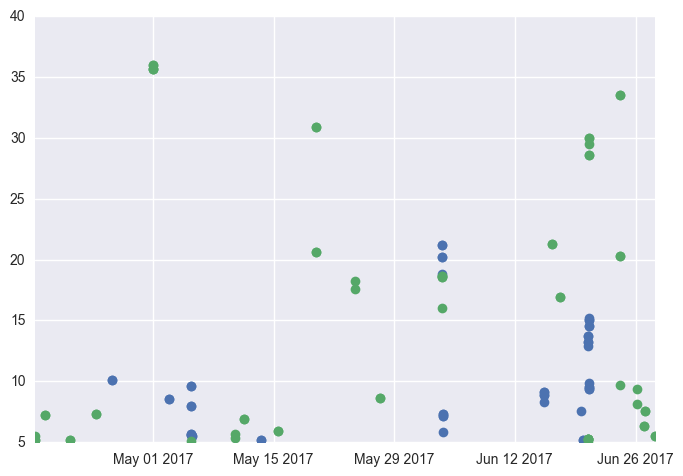

In [8]:
plt.plot(pegasor['time'][pegasor['ldsa-1/2']>5],pegasor['ldsa-1/2'][pegasor['ldsa-1/2']>5],'o')
plt.plot(pegasor['time'][pegasor['ldsa-2/1']>5],pegasor['ldsa-2/1'][pegasor['ldsa-2/1']>5],'o')

In [9]:
pegasor=pegasor[pegasor['ldsa-2/1']<5]
pegasor=pegasor[pegasor['ldsa-1/2']<5].reset_index()
del pegasor['index'], pegasor['ldsa-1/2'], pegasor['ldsa-2/1']

In [87]:
times=pd.DatetimeIndex(pegasor.time)
peg_grouped=pegasor.groupby([times.month, times.day]).mean().reset_index()
peg_grouped=peg_grouped.rename(columns={'level_0':'month','level_1':'day'})
peg_grouped['year']=2017
peg_grouped['date']=pd.to_datetime(peg_grouped[['year','month','day']])
del peg_grouped['year'], peg_grouped['month'], peg_grouped['day']

In [62]:
# time beginning FRM
frm=pd.read_excel('/Users/stella/Desktop/queens-data/FRM_PM25_Conc_Queens.xlsx')
frm.columns=['time','FRM PM2.5 (ug/m3)']
frm=frm[1:-8].reset_index()
del frm['index']
frm['time']=frm['time'].apply(lambda x: parse(x))
frm['FRM PM2.5 (ug/m3)']=pd.to_numeric(frm['FRM PM2.5 (ug/m3)'], errors='coerce')
frm['FRM PM2.5 (ug/m3)']=frm['FRM PM2.5 (ug/m3)'].dropna()

# apr1 - sep3
# hourly time beginning averages

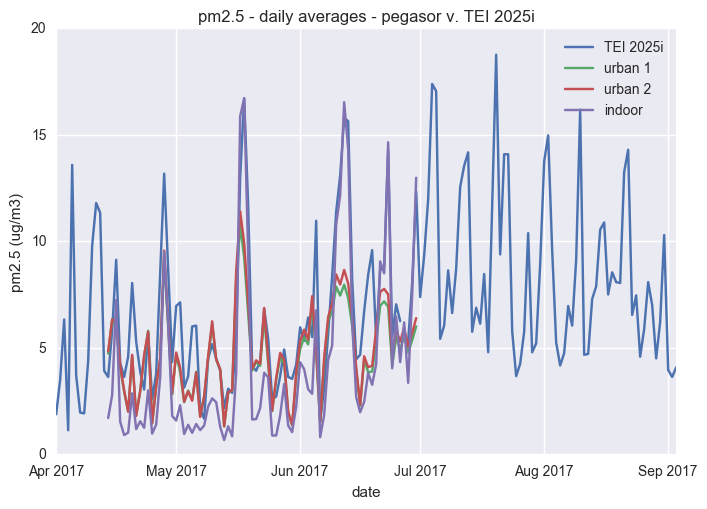

In [99]:
plt.plot(frm['time'],frm['FRM PM2.5 (ug/m3)'],label='TEI 2025i')
plt.plot(peg_grouped['date'],peg_grouped['pm25-1']*5,label='urban 1')
plt.plot(peg_grouped['date'],peg_grouped['pm25-2']*5,label='urban 2')
plt.plot(peg_grouped['date'],peg_grouped['i-pm25'],label='indoor')
plt.legend()
plt.ylabel('pm2.5 (ug/m3)')
plt.xlabel('date')
plt.title('pm2.5 - daily averages - pegasor v. TEI 2025i')

In [ ]:
peg_grouped=peg_grouped[['date','i-pm25','pm25-1','pm25-2']]

In [182]:
teom1=pd.read_excel(path+'queens-data/Queens Data Logger TEOM 1 Hour Data February to April.xls')
teom1=teom1.rename(columns=teom1.iloc[1])[3:-8]
teom1['Date&Time']=teom1['Date&Time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M %p'))
teom1=teom1[['Date&Time','PM2.5_FEM_MC']].reset_index()
teom1=teom1.rename(columns={'Date&Time':'time'})
del teom1['index']
teom1['PM2.5_FEM_MC']=pd.to_numeric(teom1['PM2.5_FEM_MC'], errors='coerce')

times=pd.DatetimeIndex(teom1.time)
teom1_grouped=teom1.groupby([times.month, times.day]).mean().reset_index()
teom1_grouped=teom1_grouped.rename(columns={'level_0':'month','level_1':'day'})
teom1_grouped['year']=2017
teom1_grouped['date']=pd.to_datetime(teom1_grouped[['year','month','day']])
del teom1_grouped['year'], teom1_grouped['month'], teom1_grouped['day']

In [183]:
teom2=pd.read_csv(path+'TEOM_TSI 3783_May-June_2017.csv')[:-9]
#teom2=teom2.rename(columns=teom2.iloc[])
teom2=teom2[1:]
teom2=teom2[['﻿Date&Time','PM2.5_FEM_MC']]
teom2['﻿Date&Time']=teom2['﻿Date&Time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %I:%M %p'))
teom2['PM2.5_FEM_MC']=pd.to_numeric(teom2['PM2.5_FEM_MC'], errors='coerce')
#teom2=teom2[teom2['PM2.5_FEM_MC']>0]
teom2=teom2.reset_index()
del teom2['index']
teom2=teom2.rename(columns={'﻿Date&Time':'time'})

times=pd.DatetimeIndex(teom2.time)
teom2_grouped=teom2.groupby([times.month, times.day]).mean().reset_index()
teom2_grouped=teom2_grouped.rename(columns={'level_0':'month','level_1':'day'})
teom2_grouped['year']=2017
teom2_grouped['date']=pd.to_datetime(teom2_grouped[['year','month','day']])
del teom2_grouped['year'], teom2_grouped['month'], teom2_grouped['day']

In [194]:
path2='/Users/stella/Desktop/CHTechUSA Data_2017_1002/'
df2=pd.read_csv(path2+'TEOM-1405DF_A225741308_2017-10-2_13-0-27.csv')
df2 = df2.rename(columns=df2.iloc[2])[3:].reset_index()
del df2['index']
df2 = df2[['Time Stamp','PM-2.5 FEM MC']]
df2 = df2.rename(columns={'Time Stamp':'time','PM-2.5 FEM MC':'PM2.5_FEM_MC'})

df2['time']=df2['time'].apply(lambda x: parse(x))
df2['PM2.5_FEM_MC']=pd.to_numeric(df2['PM2.5_FEM_MC'], errors='coerce')

times=pd.DatetimeIndex(df2.time)
teom3_grouped=df2.groupby([times.month, times.day]).mean().reset_index()
teom3_grouped=teom3_grouped.rename(columns={'level_0':'month','level_1':'day'})
teom3_grouped['year']=2017
teom3_grouped['date']=pd.to_datetime(teom3_grouped[['year','month','day']])
del teom3_grouped['year'], teom3_grouped['month'], teom3_grouped['day']
teom3_grouped=teom3_grouped[1:]

In [199]:
teom=pd.concat([teom1_grouped,teom2_grouped,teom3_grouped])
teom=teom[(teom['date']>=datetime.date(2017,4,1)) & (teom['date']<datetime.date(2017,10,1))]

In [208]:
teom.head()

,PM2.5_FEM_MC,date
59,0.623333,2017-04-01
60,2.397917,2017-04-02
61,5.468333,2017-04-03
62,4.397917,2017-04-04
63,12.376667,2017-04-05


(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 <a list of 7 Text yticklabel objects>)

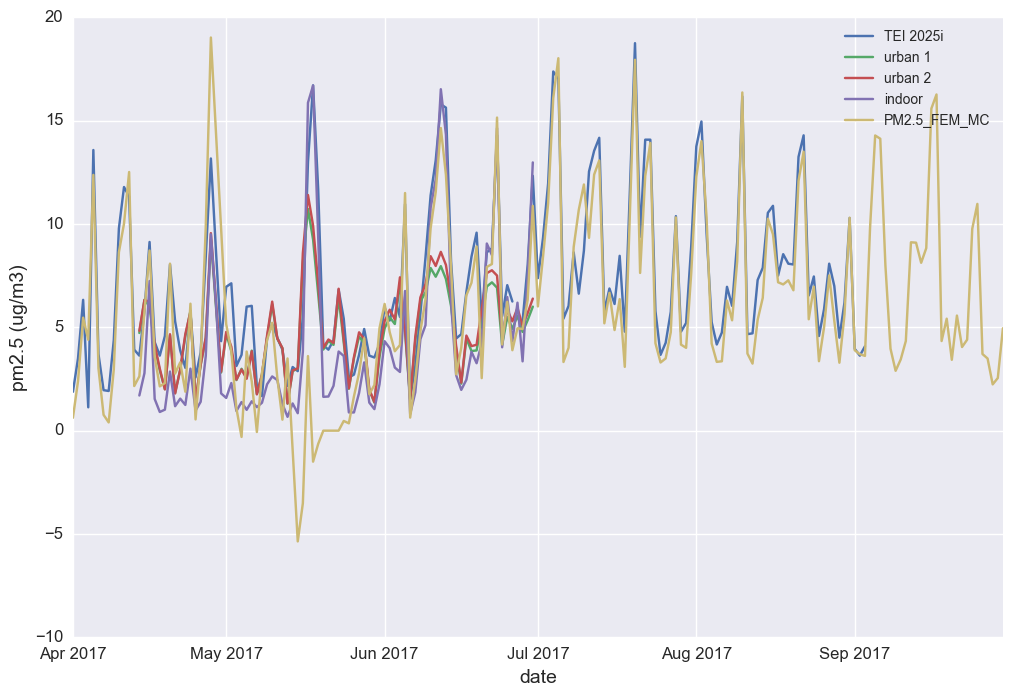

In [265]:
plt.figure(figsize=(12,8))
plt.plot(frm['time'],frm['FRM PM2.5 (ug/m3)'],label='TEI 2025i')
plt.plot(peg_grouped['date'],peg_grouped['pm25-1']*5,label='urban 1')
plt.plot(peg_grouped['date'],peg_grouped['pm25-2']*5,label='urban 2')
plt.plot(peg_grouped['date'],peg_grouped['i-pm25'],label='indoor')
plt.plot(teom['date'],teom['PM2.5_FEM_MC'])
plt.legend()
plt.ylabel('pm2.5 (ug/m3)',fontsize=14)
plt.xlabel('date',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('pm2.5 - daily averages - pegasor v. TEI 2025i')

In [236]:
pm25=peg_grouped.set_index('date').join(frm.set_index('time')).join(teom.set_index('date')).reset_index()

In [240]:
pm25.head()

,date,i-pm25,pm25-1,pm25-2,FRM PM2.5 (ug/m3),PM2.5_FEM_MC
0,2017-04-14,1.702340,0.945628,0.966228,3.63,2.628333
1,2017-04-15,2.785118,1.266922,1.265157,5.79,5.767500
2,2017-04-16,7.243579,1.203546,1.246592,9.13,8.716667
3,2017-04-17,1.535411,0.809476,0.835263,4.29,3.567083
4,2017-04-18,0.904722,0.584453,0.600565,3.63,2.143750


In [288]:
pm25['date']

0    2017-04-14
1    2017-04-15
2    2017-04-16
3    2017-04-17
4    2017-04-18
5    2017-04-19
6    2017-04-20
7    2017-04-21
8    2017-04-22
9    2017-04-23
10   2017-04-24
11   2017-04-25
12   2017-04-26
13   2017-04-27
14   2017-04-28
15   2017-04-29
16   2017-04-30
48   2017-06-01
49   2017-06-02
50   2017-06-03
51   2017-06-04
52   2017-06-05
53   2017-06-06
54   2017-06-07
55   2017-06-08
56   2017-06-09
57   2017-06-10
58   2017-06-11
59   2017-06-12
60   2017-06-13
61   2017-06-14
62   2017-06-15
63   2017-06-16
64   2017-06-17
65   2017-06-18
66   2017-06-19
67   2017-06-20
68   2017-06-21
69   2017-06-22
70   2017-06-23
71   2017-06-24
72   2017-06-25
73   2017-06-26
74   2017-06-27
75   2017-06-28
76   2017-06-29
77   2017-06-30
Name: date, dtype: datetime64[ns]

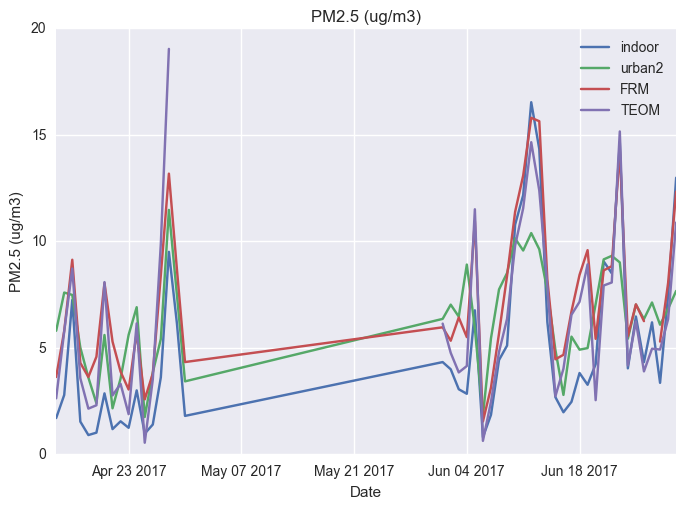

In [290]:
plt.plot(pm25['date'],pm25['i-pm25'],label='indoor')                 # blue
#plt.plot(pm25['date'],pm25['pm25-1'],label='urban1')                # green
plt.plot(pm25['date'],pm25['pm25-2']*6,label='urban2')               # red
plt.plot(pm25['date'],pm25['FRM PM2.5 (ug/m3)'],label='FRM')         # purple
plt.plot(pm25['date'],pm25['PM2.5_FEM_MC'],label='TEOM')             # gold
plt.legend()
plt.title('PM2.5 (ug/m3)')
plt.ylabel('PM2.5 (ug/m3)')
plt.xlabel('Date')

In [286]:
pd.DataFrame.corr(pm25)

,i-pm25,pm25-1,pm25-2,FRM PM2.5 (ug/m3),PM2.5_FEM_MC
i-pm25,1.000000,0.760786,0.787304,0.925872,0.830389
pm25-1,0.760786,1.000000,0.997152,0.731444,0.728093
pm25-2,0.787304,0.997152,1.000000,0.747116,0.727990
FRM PM2.5 (ug/m3),0.925872,0.731444,0.747116,1.000000,0.939123
PM2.5_FEM_MC,0.830389,0.728093,0.727990,0.939123,1.000000


In [271]:
pm25['month']=pm25['date'].apply(lambda x: x.month)

In [275]:
pm25=pm25[pm25['month']!=5]
del pm25['month']

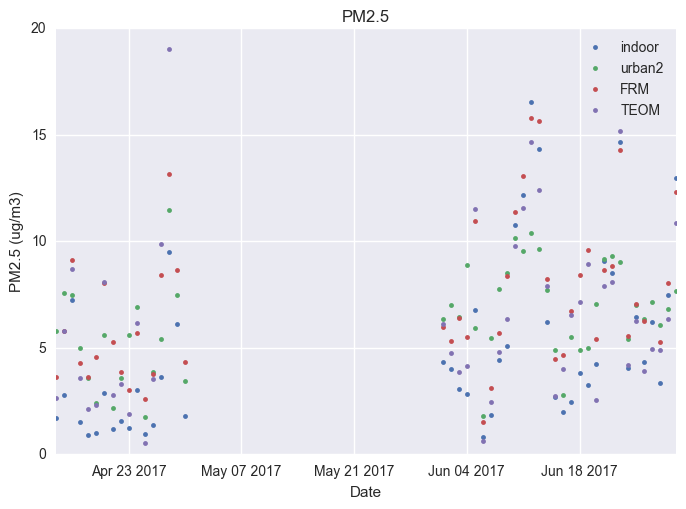

In [283]:
plt.plot(pm25['date'],pm25['i-pm25'],'.',label='indoor')                 # blue
#plt.plot(pm25['date'],pm25['pm25-1'],'.',label='urban1')                # green
plt.plot(pm25['date'],pm25['pm25-2']*6,'.',label='urban2')               # red
plt.plot(pm25['date'],pm25['FRM PM2.5 (ug/m3)'],'.',label='FRM')         # purple
plt.plot(pm25['date'],pm25['PM2.5_FEM_MC'],'.',label='TEOM')             # gold
plt.title('PM2.5')
plt.ylabel('PM2.5 (ug/m3)')
plt.xlabel('Date')
plt.legend()

In [284]:
pd.DataFrame.corr(pm25)

,i-pm25,pm25-1,pm25-2,FRM PM2.5 (ug/m3),PM2.5_FEM_MC
i-pm25,1.000000,0.760786,0.787304,0.925872,0.830389
pm25-1,0.760786,1.000000,0.997152,0.731444,0.728093
pm25-2,0.787304,0.997152,1.000000,0.747116,0.727990
FRM PM2.5 (ug/m3),0.925872,0.731444,0.747116,1.000000,0.939123
PM2.5_FEM_MC,0.830389,0.728093,0.727990,0.939123,1.000000


In [293]:
pm25['FRM PM2.5 (ug/m3)'].head()

0    3.63
1    5.79
2    9.13
3    4.29
4    3.63
Name: FRM PM2.5 (ug/m3), dtype: float64

In [295]:
pm25['PM2.5_FEM_MC'].head()

0    2.628333
1    5.767500
2    8.716667
3    3.567083
4    2.143750
Name: PM2.5_FEM_MC, dtype: float64

In [302]:
pm25['i-pm25'].head()

0    1.702340
1    2.785118
2    7.243579
3    1.535411
4    0.904722
Name: i-pm25, dtype: float64

In [301]:
pm25['pm25-1'].head()

0    0.945628
1    1.266922
2    1.203546
3    0.809476
4    0.584453
Name: pm25-1, dtype: float64

In [304]:
pm25['pm25-2'].head()

0    0.966228
1    1.265157
2    1.246592
3    0.835263
4    0.600565
Name: pm25-2, dtype: float64

In [305]:
pm25.columns

Index(['date', 'i-pm25', 'pm25-1', 'pm25-2', 'FRM PM2.5 (ug/m3)',
       'PM2.5_FEM_MC'],
      dtype='object')

In [309]:
#pm25['i-pm25'].mean()
pm25['pm25-1'].mean()
#pm25['pm25-2'].mean()
#pm25['FRM PM2.5 (ug/m3)'].mean()
#pm25['PM2.5_FEM_MC'].mean()

1.0080404805511058

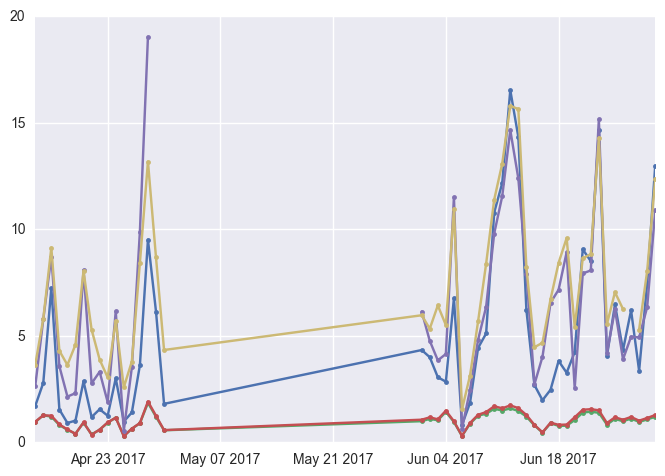

In [316]:
plt.plot(pm25['date'],pm25['i-pm25'],'.-')
plt.plot(pm25['date'],pm25['pm25-1'],'.-')
plt.plot(pm25['date'],pm25['pm25-2'],'.-')
plt.plot(pm25['date'],pm25['PM2.5_FEM_MC'],'.-')
plt.plot(pm25['date'],pm25['FRM PM2.5 (ug/m3)'],'.-')